In [1]:
# Load the pickled data
import pickle

file_location = 'D:\\5005-Data\\tweet_combined_with_sentiment.pkl'

with open(file_location, 'rb') as f:
    tweets_dict = pickle.load(f)

len(tweets_dict)

1387322

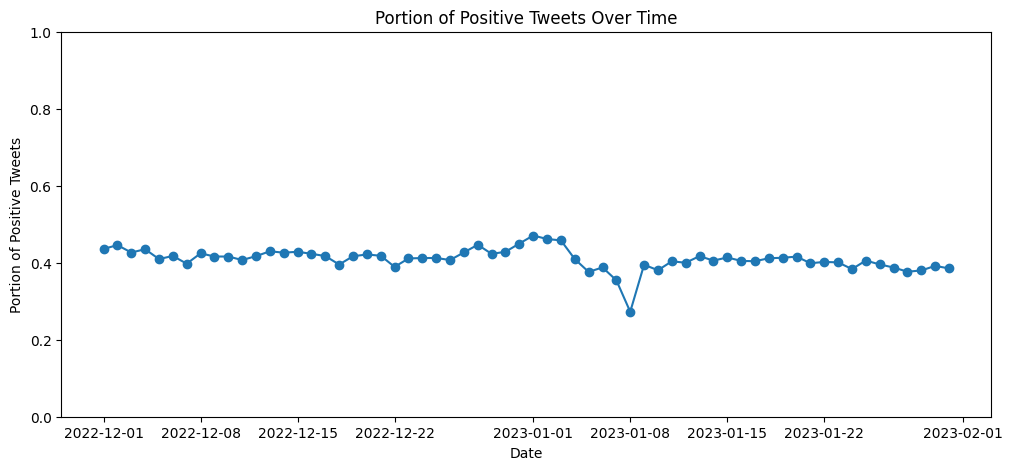

In [6]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Define the date range for which we want to plot the graph
start_date = datetime.strptime('2022-12-01', '%Y-%m-%d')
end_date = datetime.strptime('2023-01-31', '%Y-%m-%d')

# Initialize the lists to store the count of positive and negative tweets for each date
positive_counts = []
negative_counts = []
dates = []

# Iterate over the date range and count the positive and negative tweets for each date
current_date = start_date
while current_date <= end_date:
    positive_count = 0
    negative_count = 0
    for tweet in tweets_dict.values():
        tweet_datetime = tweet.date
        if tweet_datetime.date() == current_date.date():
            if tweet.sentiment == 'POSITIVE':
                positive_count += 1
            else:
                negative_count += 1
    
    positive_counts.append(positive_count)
    negative_counts.append(negative_count)
    dates.append(current_date.date())
    current_date += timedelta(days=1)

# Calculate the portion of positive tweets for each date
portion_positive = [p / (p + n) for p, n in zip(positive_counts, negative_counts)]

# Plot the graph
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(dates, portion_positive, marker="o")
ax.set_title("Portion of Positive Tweets Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Portion of Positive Tweets")
ax.set_ylim(0, 1)
plt.show()


In [45]:
import re

def remove_urls_and_entities(text):
    """
    Removes URLs and HTML entities from a string using regular expressions.
    
    Args:
        text (str): The input string to remove URLs and HTML entities from.
        
    Returns:
        str: The input string with any URLs and HTML entities removed.
    """
    # Define regular expressions to match URLs and HTML entities
    url_pattern = re.compile(r'https?://(?:www\.\S+|(?!www)\S+)')
    entity_pattern = re.compile(r'&\w+;')
    
    # Use the sub() method to replace URLs and HTML entities with an empty string
    text_without_urls_and_entities = url_pattern.sub('', text)
    text_without_urls_and_entities = entity_pattern.sub('', text_without_urls_and_entities)
    
    return text_without_urls_and_entities


def remove_common_words(string):
    pattern = re.compile(r"(#|)ChatGPT", re.IGNORECASE)
    clean_string = re.sub(pattern, "", string)
    clean_string = clean_string.replace('AI', '')
    clean_string = clean_string.replace('will', '')
    clean_string = clean_string.replace('OpenAI', '')
    clean_string = clean_string.replace('Open', '')
    clean_string = clean_string.replace('use', '')
    clean_string = clean_string.replace('using', '')
    return clean_string


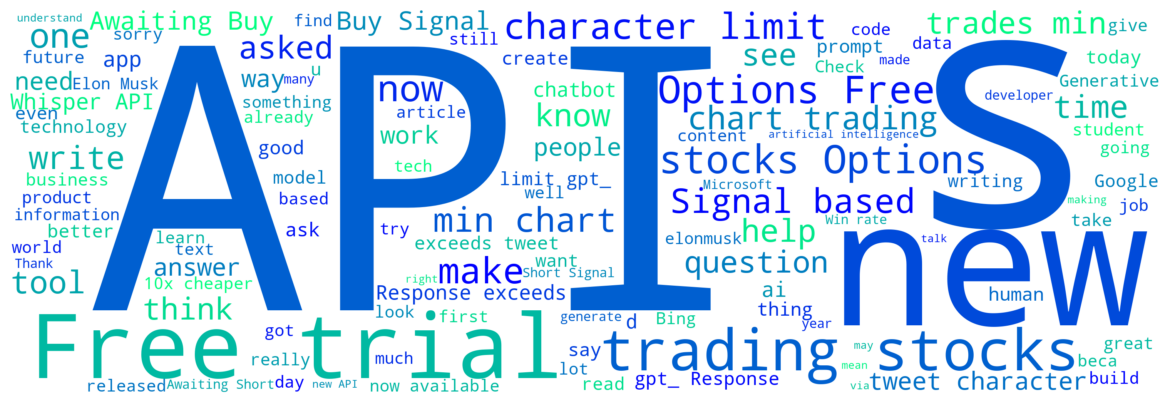

In [53]:
from wordcloud import WordCloud

def create_word_cloud(target, tweets_dict):
    texts = []
    for tweet in tweets_dict.values():
        tweet_datetime = tweet.date
        if tweet_datetime.date() == target.date():
            content = remove_urls_and_entities(tweet.rawContent)
            content = remove_common_words(content)
            texts.append(content)

    # Create a WordCloud object
    texts = ' '.join(texts)
    wordcloud = WordCloud(width=3000, height=1000, background_color='white', max_words=120, contour_width=3, prefer_horizontal=1, colormap='winter')
    wordcloud.generate(texts)
    return wordcloud

date = datetime.strptime('2023-03-01', '%Y-%m-%d')
cloud = create_word_cloud(date, tweets_dict)

fig, ax = plt.subplots(figsize=(15, 5))

plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()